# Capstone Project:  Face Shape Classification - Part 3

This notebook explores Convolutional Neural Network (CNN) Models on different image datasets based on the following image preprocessing:

- Model 1: Auto resized to 224 x 224
- Model 2: Images are cropped & resized by maintaining aspect ratio
- Model 3: Face Detection with Bounding Box in Grayscale
- Model 4: Face Detection with Bounding Box in Color (RGB)

This is initial exploratory phase to see which model generates the highest accuracy, while minimizing overfitting (gap between validation accuracy vs. training accuracy).  We will also plot confusion matrix to see how accurate is the model predicting each class (in this case, face shape).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torch.nn import Linear, Dropout, Flatten, Conv2d, MaxPool2d, AdaptiveAvgPool2d
from torch.nn import functional as F
import pandas as pd
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

#### Define Functions

In [ ]:
def plot_results(mod_history, metric, epochs):

      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [ ]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()



In [ ]:
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

## <span style = 'color:sienna'>Model 1: GRAYSCALE images - resize to 224x224</span>  

In [ ]:
path = "/content/drive/MyDrive/CV Project/"

X_train = np.asarray(pickle.load(open(path + "X_train_r224.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_r224.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_r224.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_r224.pickle","rb")))

In [ ]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (510, 224, 224, 1)
y_train shape (510, 5)
--------------------
X_test shape (125, 224, 224, 1)
y_test shape (125, 5)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Input shape should be (1, 224, 224) for grayscale
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # (8, 224, 224)
        self.pool = nn.MaxPool2d(2, 2)  # (8, 112, 112)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # (16, 112, 112)
        self.pool2 = nn.MaxPool2d(2, 2)  # (16, 56, 56)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, padding=1)  # (64, 56, 56)
        self.pool3 = nn.MaxPool2d(2, 2)  # (64, 28, 28)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (128, 28, 28)
        self.pool4 = nn.MaxPool2d(2, 2)  # (128, 14, 14)

        # Calculate flattened size
        self.flattened_size = 128 * 14 * 14

        self.fc1 = nn.Linear(self.flattened_size, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # ❗ No softmax here
        return x


# Convert your data to proper PyTorch format (NCHW)
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()  # From NHWC to NCHW
X_test = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()

# Initialize model
model_1 = CNN()
print(model_1)

# Verify input/output shapes
dummy_input = torch.randn(1, 1, 224, 224)  # Batch of 1, 1 channel, 224x224
output = model_1(dummy_input)
print(f"Output shape: {output.shape}")  # Should be [1, 5]

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
)
Output shape: torch.Size([1, 5])


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

'''Uncomment while running 1st time'''
# Convert y_train and y_test to torch tensors (assumed to be integers for classification)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model, loss, optimizer
model_1 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

# To track history
history_1 = {'train_loss': [], 'val_loss': [], 'val_acc': []}

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)

# Training loop
epochs = 50
for epoch in range(epochs):
    model_1.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_1(images)

        labels = labels.argmax(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    history_1['train_loss'].append(epoch_loss)

    # Validation
    model_1.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_1(val_images)

            # Convert val_labels to class indices
            val_labels_indices = val_labels.argmax(dim=1)

            loss = criterion(val_outputs, val_labels_indices) # Use class indices for loss calculation
            val_loss += loss.item() * val_images.size(0)

            preds = torch.argmax(val_outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels_indices.cpu().numpy()) # Store class indices in all_labels

    val_loss /= len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    history_1['val_loss'].append(val_loss)
    history_1['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/50] Train Loss: 1.6177 | Val Loss: 1.6132 | Val Acc: 0.2000
Epoch [2/50] Train Loss: 1.6119 | Val Loss: 1.6129 | Val Acc: 0.2000
Epoch [3/50] Train Loss: 1.6101 | Val Loss: 1.6117 | Val Acc: 0.2000
Epoch [4/50] Train Loss: 1.6139 | Val Loss: 1.6117 | Val Acc: 0.2000
Epoch [5/50] Train Loss: 1.6115 | Val Loss: 1.6116 | Val Acc: 0.2000
Epoch [6/50] Train Loss: 1.6114 | Val Loss: 1.6118 | Val Acc: 0.2000
Epoch [7/50] Train Loss: 1.6090 | Val Loss: 1.6117 | Val Acc: 0.2000
Epoch [8/50] Train Loss: 1.6141 | Val Loss: 1.6112 | Val Acc: 0.2080
Epoch [9/50] Train Loss: 1.6124 | Val Loss: 1.6115 | Val Acc: 0.2000
Epoch [10/50] Train Loss: 1.6108 | Val Loss: 1.6114 | Val Acc: 0.2000
Epoch [11/50] Train Loss: 1.6104 | Val Loss: 1.6115 | Val Acc: 0.2000
Epoch [12/50] Train Loss: 1.6102 | Val Loss: 1.6112 | Val Acc: 0.2000
Epoch [13/50] Train Loss: 1.6082 | Val Loss: 1.6109 | Val Acc: 0.2000
Epoch [14/50] Train Loss: 1.6069 | Val Loss: 1.6117 | Val Acc: 0.2000
Epoch [15/50] Train Loss: 1.6

In [ ]:
max_val_acc = max(history_1['val_acc']) #❗ Use history_1 as this was updated during training
best_epoch = history_1['val_acc'].index(max_val_acc) + 1 #❗ Use history_1 as this was updated during training

print(f"\nBest validation accuracy: {max_val_acc:.4f} at epoch {best_epoch}")


Best validation accuracy: 0.2320 at epoch 35


Maximum validation accuracy is 42.7%, however is highly overfitting compared to training accuracy of 73.9%.

In [ ]:
def evaluate(model, X_test, y_test, batch_size=4):
    # Set model to evaluation mode
    model.eval()

    # Create DataLoader
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize metrics
    test_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)

            labels = labels.argmax(dim=1).long()

            loss = F.cross_entropy(outputs, labels)

            # Update metrics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate final metrics
    test_loss = test_loss / total
    test_acc = correct / total

    return test_loss, test_acc

# Usage example:
test_loss, test_acc = evaluate(model_1, X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.6221, Test Accuracy: 0.2240


In [ ]:
def plot_results(mod_history, metric, epochs):
    """
    Plots training and validation metrics over epochs.

    Args:
        mod_history (dict): Dictionary containing training history
        metric (str): Metric to plot ('loss' or 'acc')
        epochs (int): Number of training epochs
    """
    plt.figure(figsize=(10, 5))

    # Get the metrics
    # Changed from 'train_{metric}' to 'train_loss' if metric is 'acc'
    train_metric = mod_history[f'train_{metric}'] if metric != 'acc' else mod_history['train_loss']
    val_metric = mod_history[f'val_{metric}'] if f'val_{metric}' in mod_history else mod_history[f'val_acc'] if metric == 'acc' else None #❗ Added check for val_acc

    # Create epochs range
    epochs_range = range(1, epochs + 1)

    # Plot the metrics
    plt.plot(epochs_range, train_metric, label=f'Training {metric}')
    if val_metric is not None: #❗ Only plot if val_metric is available
        plt.plot(epochs_range, val_metric, label=f'Validation {metric}')

    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_summary_results(mod_name, mod_history, epochs):
    """
    Plots loss and accuracy curves and makes predictions.

    Args:
        mod_name: PyTorch model
        mod_history (dict): Training history dictionary
        epochs (int): Number of training epochs
    """
    # Plot loss and accuracy
    plot_results(mod_history, 'loss', epochs)
    plot_results(mod_history, 'acc', epochs)  # Changed from 'accuracy' to 'acc'

    # If you have a make_predictions function, call it here
    # make_predictions(mod_name)

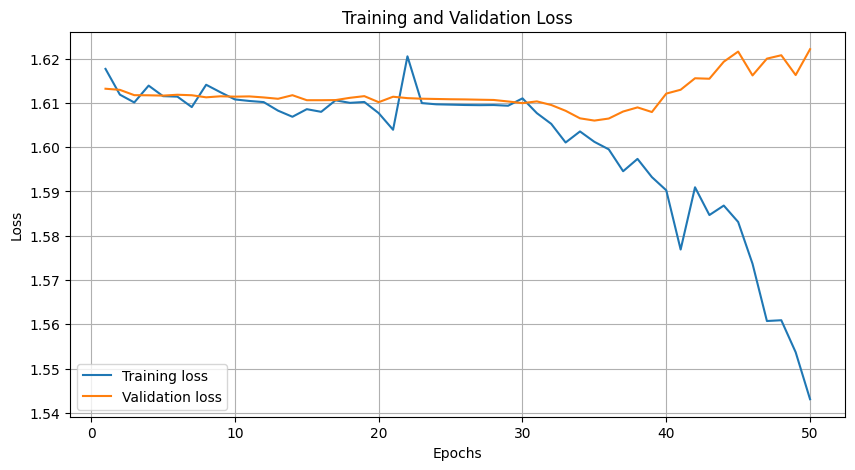

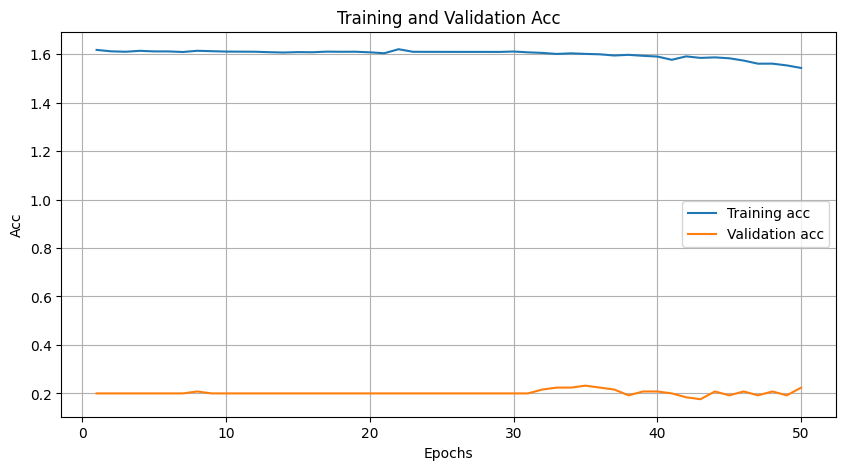

In [ ]:
plot_summary_results(model_1, history_1, 50)

## Save the model and weights

In [ ]:


model_path = '/content/drive/MyDrive/CV Project/save models/'
filename = model_path + 'rgb_oct12_3.pth'  # change the filename for new iterations

# Save the model's state_dict and optimizer's state_dict
torch.save({
    'model_state_dict': model_1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, filename)